<a href="https://colab.research.google.com/github/anshg05/Machine-Learning-Lab/blob/main/Speech_Recognition_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install librosa numpy pandas scikit-learn tensorflow matplotlib

In [2]:
!pip install librosa
!pip install resampy
!pip install soundfile

In [3]:
import zipfile

# Adjust the filename if needed
zip_path = "/content/archive.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/ravdess_data")


In [4]:
import os
import librosa
import numpy as np

# Define emotions mapping
emotion_labels = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# Function to extract features
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    return mfccs_scaled

# Prepare data
X, y = [], []

directory = "/content/ravdess_data/"

for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)

            # Extract emotion from filename
            part = file.split("-")
            emotion = emotion_labels.get(part[2])

            features = extract_features(file_path)
            X.append(features)
            y.append(emotion)

print(f"Extracted features from {len(X)} files.")


Extracted features from 2880 files.


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

# Encode the labels (emotion labels) into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Training data size: {X_train.shape[0]}")
print(f"Testing data size: {X_test.shape[0]}")

Training data size: 2304
Testing data size: 576


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Model Accuracy: 92.01%

Classification Report:
              precision    recall  f1-score   support

       angry       0.97      0.92      0.95        78
        calm       0.88      0.97      0.93        78
     disgust       0.94      0.97      0.96        69
     fearful       0.90      0.92      0.91        76
       happy       0.92      0.94      0.93        70
     neutral       0.95      0.86      0.90        44
         sad       0.91      0.82      0.86        76
   surprised       0.91      0.93      0.92        85

    accuracy                           0.92       576
   macro avg       0.92      0.92      0.92       576
weighted avg       0.92      0.92      0.92       576



In [8]:
from sklearn.model_selection import GridSearchCV

# Set up hyperparameters grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV with RandomForest
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get best parameters and accuracy
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found:  {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.88


In [9]:
import joblib

# Save the trained model
joblib.dump(rf_classifier, 'speech_emotion_recognizer_model.pkl')

# To load it back later
# loaded_model = joblib.load('speech_emotion_recognizer_model.pkl')

['speech_emotion_recognizer_model.pkl']

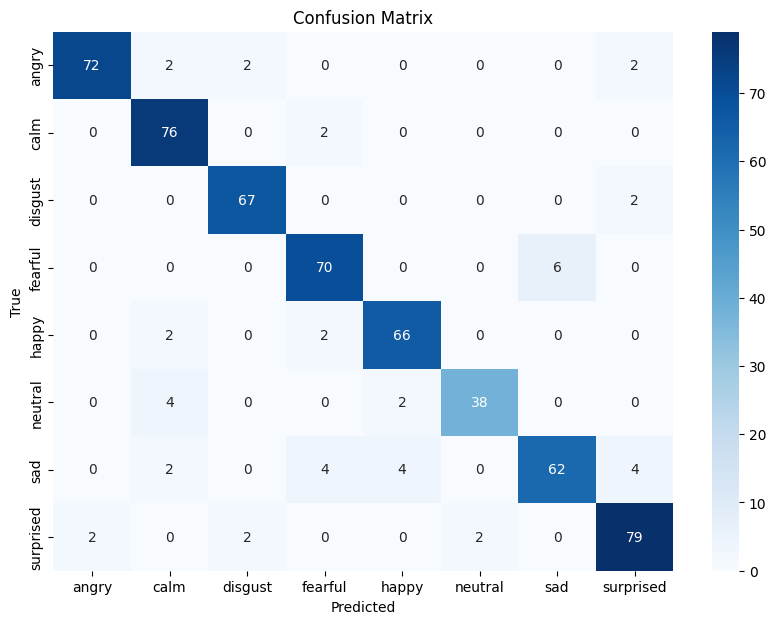

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [21]:
import joblib

# Load the trained model
model = joblib.load('speech_emotion_recognizer_model.pkl')

In [22]:
from sklearn.model_selection import cross_val_score

# Cross-validation to evaluate model performance
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)


Cross-validation scores: [1.         1.         1.         1.         0.95833333]


In [30]:
import librosa
import numpy as np

# Function to extract features from the audio file
def extract_features(file_path):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None)

    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mfccs = np.mean(mfccs.T, axis=0)  # Taking the mean of the MFCC features over time
    return mfccs

# Path to the new audio file
file_path = '/content/ravdess_data/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-02-01.wav'

# Extract features from the audio file
features = extract_features(file_path)
features = features.reshape(1, -1)  # Reshape for a single sample prediction

In [31]:
# Predict the emotion for the new audio file
predicted_emotion = model.predict(features)

# Map the prediction to the corresponding emotion label
emotion_labels = {0: 'angry', 1: 'calm', 2: 'disgust', 3: 'fearful', 4: 'happy',
                  5: 'neutral', 6: 'sad', 7: 'surprised'}

# Get the predicted emotion label
predicted_emotion_label = emotion_labels[predicted_emotion[0]]

print(f"The predicted emotion is: {predicted_emotion_label}")

The predicted emotion is: calm
